# Title: CNN model to predict antibiotic resistance of different strains
### Team members
**Gian Carlo L. Baldonado**
**, Estefanos Kebebew**
**, Jameel Ali**


## Step 1: Import packges

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import time
import os
import random
from sklearn.model_selection import train_test_split
import torch

## Load the file

In [3]:
giessen_orig = pd.read_csv("/content/cip_ctx_ctz_gen_multi_data.csv")

In [4]:
giessen_orig.tail()

,prename,X393,X588,X747,X759,X774,X966,X1299,X1302,X1407,...,X4639956.3,X4640785.3,X4640908.3,X4640924.3,X4641031.3,X4641131.3,X4641217.3,X4641296.3,X4641439.3,X4641440.3
804,wwRBK-17-0298-1_S42,0,0,2,4,3,3,0,0,4,...,3,4,0,0,2,3,1,3,3,1
805,wwRBK-17-075-1_S28,2,1,2,4,3,3,3,3,4,...,3,4,4,2,1,3,1,3,3,1
806,wwRBL-16-111-1_S16,2,0,0,0,3,0,3,3,4,...,3,4,0,0,0,3,0,0,0,0
807,wwRBL-17-004-1_S44,2,1,2,4,3,3,3,3,4,...,3,4,4,2,1,3,1,3,3,1
808,WWSurvcare043_S43,2,1,2,4,3,3,3,3,4,...,3,4,4,2,1,3,1,3,3,1


In [5]:
giessen_orig.shape

(809, 60937)

## Create a copy of the orginal file

In [6]:
df = giessen_orig.copy()

Drop the first coloumn

In [7]:
gene_df = df.drop(columns=["prename"])
gene_df.tail()

,X393,X588,X747,X759,X774,X966,X1299,X1302,X1407,X1425,...,X4639956.3,X4640785.3,X4640908.3,X4640924.3,X4641031.3,X4641131.3,X4641217.3,X4641296.3,X4641439.3,X4641440.3
804,0,0,2,4,3,3,0,0,4,0,...,3,4,0,0,2,3,1,3,3,1
805,2,1,2,4,3,3,3,3,4,2,...,3,4,4,2,1,3,1,3,3,1
806,2,0,0,0,3,0,3,3,4,0,...,3,4,0,0,0,3,0,0,0,0
807,2,1,2,4,3,3,3,3,4,2,...,3,4,4,2,1,3,1,3,3,1
808,2,1,2,4,3,3,3,3,4,2,...,3,4,4,2,1,3,1,3,3,1


**Task: Find the dimension of image before converting the genotype sequence in the form of an image**
https://www.frontiersin.org/files/Articles/914435/fbinf-02-914435-HTML/image_m/fbinf-02-914435-g005.jpg

1. Let N be the length of the genotype sequence.
2. Take the sqrt of N and suppose it is M. Extract 0 to the square of M sequence from the genotype data.

In [8]:
no_isolates = gene_df.shape[0]
N = gene_df.shape[1]
print("Length of genotype sequence:",N)

Length of genotype sequence: 60936


####Create a function that encodes a sequence into a square image by reshaping then return the image data

In [9]:
def encode_seq_to_image(seq):
    N = len(seq)
    M = int(np.sqrt(N))
    image_data = np.array(seq[:M*M]).reshape(M,M)
    return image_data

###Generates a 2D heatmap image from an array and saves it as a PNG file.

In [10]:
## Heatmap
def heatmap2d(name, arr, cmap='viridis'):
    output_folder = "output_images"
    fig = plt.figure()
    plt.imshow(arr, cmap=cmap)
    plt.axis('off')
    plt.savefig(os.path.join(output_folder, f'{name}.png'))
    plt.close(fig)

## Color mapping
* 0 = Null = white,
* 1 = A = red
* 2 = C = green
* 3 = G = yellow
* 4 = T = blue

### The fucntion below took the genotype sequence as input. Following that it follows this steps:
  * Encode the genotype sequences into 2D matrices,
  * Creats a visualizations of each 2D matrix as PNG images
  * Returs a dictionary where the keys are the names of isolates and the values are the 2D matrix representations of the genotype sequences.

In [11]:
def process_encoding(file_path):

    ###
    # Processes a csv file containing genotype sequences,
    # encodes the genotype sequences into 2d matrices,
    # creates visualizations for each 2d matrices as .pngs,
    # and returns a dict where keys are name of isolates and values are 2d matrix representation of the genotype sequences.

    # Input: file_path: str, path to the csv file
    # Output: image_data_dict, dict containing isolate name (key) and its 2d-encoded gene sequences (values)

    print("Start encoding process of genotype sequences to images.")

    start_time = time.time()
    print("1. Reading and processing CSV.")

    df = pd.read_csv(file_path)
    gene_df = df.drop(columns=["prename"])

    isolate_list = df["prename"]
    gene_lists = gene_df.values.tolist()
    genotype_seq_dict = dict(zip(isolate_list, gene_lists))

    no_of_isolates = len(isolate_list)
    len_of_genes = gene_df.shape[1]
    M = int(np.sqrt(len_of_genes))
    print("Number of isolates:", no_of_isolates)
    print("Length of genotype sequence:", len_of_genes)
    print(f"Image dimensions: {M} x {M}")

    print("2. Encoding...")
    # Encode

    image_data_dict = dict()
    for k,v in genotype_seq_dict.items(): # k = name, v = gene sequence
        image_data = encode_seq_to_image(v)
        image = heatmap2d(k, image_data)
        image_data_dict[k] = image_data

    end_time = time.time()
    duration = np.round(end_time-start_time, 2)
    print("Finished encoding process. Duration:", duration, " seconds.")

    return image_data_dict


In [ ]:
process_encoding("/content/cip_ctx_ctz_gen_multi_data.csv")

### Merge the two datasets

In [12]:
def merge_X_y(X_df, y_df):
    """
    X_df, file path to the feature file
    y_df, file path to the label file
    """
    X = pd.read_csv(X_df)
    y = pd.read_csv(y_df)

    # merge logic
    Xy = X.merge(y)
    return Xy

In [13]:
merge_df = merge_X_y(X_df="/content/cip_ctx_ctz_gen_multi_data.csv", y_df="/content/cip_ctx_ctz_gen_pheno.csv")
merge_df.head()

,prename,X393,X588,X747,X759,X774,X966,X1299,X1302,X1407,...,X4641031.3,X4641131.3,X4641217.3,X4641296.3,X4641439.3,X4641440.3,CIP,CTX,CTZ,GEN
0,H100_S2_L001,2,1,2,4,3,3,3,3,4,...,1,3,1,3,3,1,0,1,0,0
1,H105_S3_L001,2,1,2,4,3,3,3,3,4,...,1,3,1,3,3,1,1,1,0,0
2,H108_S5_L001,2,1,2,4,3,3,0,0,4,...,1,3,1,3,3,1,0,1,0,0
3,H109_S2_L001,2,1,2,4,3,3,3,3,4,...,1,3,1,3,3,1,0,1,0,0
4,H113_S6_L001,0,0,2,4,3,3,3,3,4,...,2,3,1,3,3,1,1,1,0,0


The first model will be trained to predict the dug resistance of CTX. In order to do that we decided to drop the other column.

In [14]:
# Drop other drug columns
drugs_to_drop = ['CTX', 'GEN', 'CTZ']
merge_df.drop(drugs_to_drop, axis=1, inplace=True)

In [15]:
# Move 'CIP' column to the second position
cip_column = merge_df.pop('CIP')
merge_df.insert(1, 'CIP', cip_column)
merge_df.tail()

,prename,CIP,X393,X588,X747,X759,X774,X966,X1299,X1302,...,X4639956.3,X4640785.3,X4640908.3,X4640924.3,X4641031.3,X4641131.3,X4641217.3,X4641296.3,X4641439.3,X4641440.3
804,wwRBK-17-0298-1_S42,1,0,0,2,4,3,3,0,0,...,3,4,0,0,2,3,1,3,3,1
805,wwRBK-17-075-1_S28,1,2,1,2,4,3,3,3,3,...,3,4,4,2,1,3,1,3,3,1
806,wwRBL-16-111-1_S16,1,2,0,0,0,3,0,3,3,...,3,4,0,0,0,3,0,0,0,0
807,wwRBL-17-004-1_S44,1,2,1,2,4,3,3,3,3,...,3,4,4,2,1,3,1,3,3,1
808,WWSurvcare043_S43,1,2,1,2,4,3,3,3,3,...,3,4,4,2,1,3,1,3,3,1


##### The function retrieves the isolate name and constructs the image path using the selected isolate. It then checks if the image file exists and displays the image along with the isolate name.

* The drug resistance status for Ciprofloxacin (CIP) is extracted from the selected isolate. If the resistance value is 0, it is considered susceptible. If the resistance value is 1, it is considered resistant. The resistance status is printed alongside the isolate name

In [16]:
def display_isolate_info(merge_df, folder_path):
    num_isolates = len(merge_df)

    # Randomly select an isolate
    selected_index = random.randint(0, num_isolates - 1)
    selected_isolate = merge_df.iloc[selected_index]

    isolate_name = selected_isolate['prename']
    image_path = os.path.join(folder_path, f'{isolate_name}.png')

    if os.path.exists(image_path):
        image = plt.imread(image_path)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f'Isolate: {isolate_name}')
        plt.show()

        cip_resistance = selected_isolate['CIP']
        if cip_resistance == 0:
            resistance_status = 'Susceptible'
        elif cip_resistance == 1:
            resistance_status = 'Resistant'
        else:
            resistance_status = 'Unknown'

        print(f'Isolate Name: {isolate_name}')
        print(f'Drug Resistance (CIP): {resistance_status}')
    else:
        print(f"Image not found for isolate: {isolate_name}")

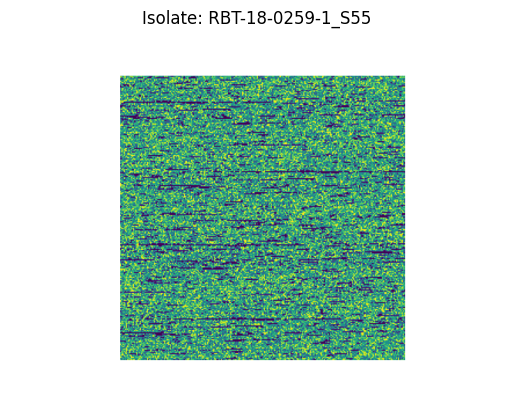

Isolate Name: RBT-18-0259-1_S55
Drug Resistance (CIP): Susceptible


In [17]:
folder_path = "/content/output_images"
display_isolate_info(merge_df, folder_path)

### Split the merged dataframe into train, test, and validation sets,

In [18]:
# Splitting the data into train, test, and validation sets
train_df, test_df = train_test_split(merge_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Printing the sizes of the split datasets
print("Train set size:", len(train_df))
print("Validation set size:", len(val_df))
print("Test set size:", len(test_df))

Train set size: 517
Validation set size: 130
Test set size: 162


Train set


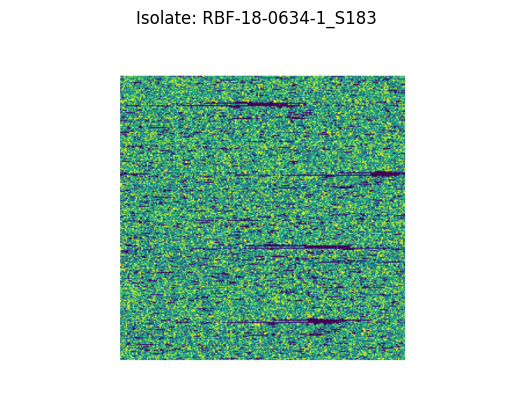

Isolate Name: RBF-18-0634-1_S183
Drug Resistance (CIP): Resistant


In [56]:
print("Train set")
display_isolate_info(train_df, folder_path)


Validation Set:


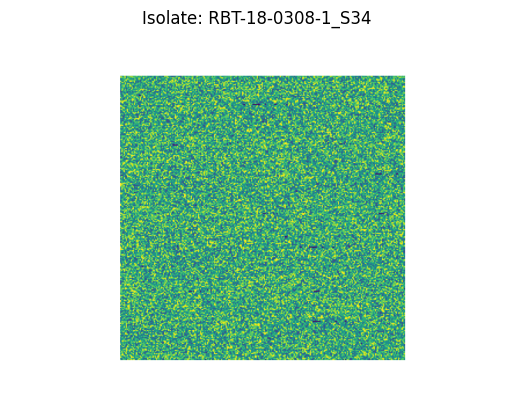

Isolate Name: RBT-18-0308-1_S34
Drug Resistance (CIP): Susceptible


In [52]:
# Display isolate from validation set
print("\nValidation Set:")
display_isolate_info(val_df, folder_path)


Test Set:


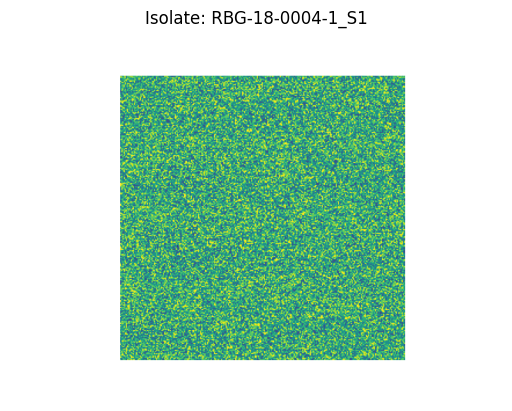

Isolate Name: RBG-18-0004-1_S1
Drug Resistance (CIP): Resistant


In [53]:
# Display isolate from test set
print("\nTest Set:")
display_isolate_info(test_df, folder_path)

### Converting the image into tensors
  * Tensors are multi-dimensional arrays that can efficiently represent and process data in
  cnn.
  * During training, it automatically compute gradients that enables efficient gradient calculation and backpropagation(update weights).

In [31]:
def load_images_as_tensors(folder_path):
    image_files = os.listdir(folder_path)
    image_paths = [os.path.join(folder_path, file) for file in image_files]
    images = []
    for path in image_paths:
        image = plt.imread(path)
        image_tensor = torch.from_numpy(image).unsqueeze(0).float()
        images.append(image_tensor)
    return torch.stack(images)

In [ ]:
train_images = load_images_as_tensors('/content/output_images/')
val_images = load_images_as_tensors('/content/output_images/')
test_images = load_images_as_tensors('/content/output_images/')